<a href="https://colab.research.google.com/github/CellerCity/DiseaseClassifcation_3_BTECH/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Installing libraries

In [ ]:
!pip install tensorflow
!pip install pylibjpeg
!pip install pydicom
!pip install pylibjpeg-libjpeg
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 54.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd '/content/gdrive/MyDrive/vindr-pcxr'

/content/gdrive/MyDrive/vindr-pcxr


In [ ]:
import matplotlib.pyplot as plt
import pydicom                                       
from pydicom.data import get_testdata_files
import pandas as pd
import numpy as np
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from PIL import Image
import cv2
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import array_to_img
from IPython.display import display, clear_output
import time

####Dataset

In [ ]:
train_labels = pd.read_csv("image_labels_train.csv")
test_labels = pd.read_csv("image_labels_test.csv")

del train_labels["rad_ID"]
del test_labels["rad_ID"]

In [ ]:
train_labels.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,6cb53aff85c71b98ad13d67a131708c6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40414c05687cdb156823c156967b13f0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e4a464dfbf8abc6333c82f1b77b6455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f4d3fab0b71381e6b237dc36301e85a0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b58c9b1c89978a0b1f8533b7a2ca1088,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_labels.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,d7e71a052a753c3f2f3e317d60177bec,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,e64d9421e78c82b5c104021a6c1b4e67,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8a12a4352a866aaea4691dd27a99c7ae,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30d6a0843a9792168fdc456c17a9028c,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f22138be08a24e79cf07f6207341e5f5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
column_names = list(train_labels.columns)
print(column_names)
diseases = column_names[1:]
print(diseases)

['image_id', 'No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']
['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']


In [ ]:
y_test = test_labels[column_names[1:]].values
print(y_test)
print (y_test[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Getting the frequency distribution of disease in test data
test_diseaseDistribution = dict.fromkeys(diseases, 0)
print(test_diseaseDistribution)

for i in range(len(y_test)):
  x = np.argmax(y_test[i])
  test_diseaseDistribution[diseases[x]] += 1

print(test_diseaseDistribution)

{'No finding': 0, 'Bronchitis': 0, 'Brocho-pneumonia': 0, 'Other disease': 0, 'Bronchiolitis': 0, 'Situs inversus': 0, 'Pneumonia': 0, 'Pleuro-pneumonia': 0, 'Diagphramatic hernia': 0, 'Tuberculosis': 0, 'Congenital emphysema': 0, 'CPAM': 0, 'Hyaline membrane disease': 0, 'Mediastinal tumor': 0, 'Lung tumor': 0}
{'No finding': 917, 'Bronchitis': 174, 'Brocho-pneumonia': 69, 'Other disease': 74, 'Bronchiolitis': 85, 'Situs inversus': 1, 'Pneumonia': 77, 'Pleuro-pneumonia': 0, 'Diagphramatic hernia': 0, 'Tuberculosis': 0, 'Congenital emphysema': 0, 'CPAM': 0, 'Hyaline membrane disease': 0, 'Mediastinal tumor': 0, 'Lung tumor': 0}


In [ ]:
diseases_to_be_considered = list()

for d,c in test_diseaseDistribution.items():
  if c == 0:
    continue
  diseases_to_be_considered.append(d)

print(diseases_to_be_considered)
print(len(diseases_to_be_considered))

['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia']
7


In [ ]:
y_train = train_labels[column_names[1:]].values
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
# print(len(y_train[0]))
# print(np.argmax(y_train[0]))

# Getting the frequency distribution of disease in training data
train_diseaseDistribution = dict.fromkeys(diseases, 0)
print(train_diseaseDistribution)

for i in range(len(y_train)):
  x = np.argmax(y_train[i])
  train_diseaseDistribution[diseases[x]] += 1

print(train_diseaseDistribution)

{'No finding': 0, 'Bronchitis': 0, 'Brocho-pneumonia': 0, 'Other disease': 0, 'Bronchiolitis': 0, 'Situs inversus': 0, 'Pneumonia': 0, 'Pleuro-pneumonia': 0, 'Diagphramatic hernia': 0, 'Tuberculosis': 0, 'Congenital emphysema': 0, 'CPAM': 0, 'Hyaline membrane disease': 0, 'Mediastinal tumor': 0, 'Lung tumor': 0}
{'No finding': 5197, 'Bronchitis': 842, 'Brocho-pneumonia': 508, 'Other disease': 385, 'Bronchiolitis': 434, 'Situs inversus': 9, 'Pneumonia': 332, 'Pleuro-pneumonia': 3, 'Diagphramatic hernia': 2, 'Tuberculosis': 2, 'Congenital emphysema': 1, 'CPAM': 1, 'Hyaline membrane disease': 10, 'Mediastinal tumor': 2, 'Lung tumor': 0}


In [ ]:
def display_image_shape(filename,new_size=(512,512),image_channels=1):
    # this function returns the corresponding image pixel array( 3 dimensional ) from the given filename
    ds = pydicom.dcmread(filename)
    #ds.PhotometricInterpretation = 'YBR_FULL'
    #print(ds)

    # Check the TransferSyntaxUID to see if the image is compressed
    if ds.file_meta.TransferSyntaxUID.is_compressed:
        # Decompress the pixel data using the appropriate algorithm
        # print("Image was compressed.")
        # print("Decompressing the image...")
        ds.decompress()

    pixel_array = ds.pixel_array
    pixel_array = np.array(pixel_array,dtype=float)
    # print('Shape:', pixel_array.shape)
    # print('Data type:', pixel_array.dtype)
    # print(pixel_array)
    # plt.imshow(pixel_array)

    img = Image.fromarray((pixel_array / 256).astype('uint8'))


    # Resize the image
    resized_img = img.resize(new_size)

    # Convert the resized image back to a numpy array
    resized_array = np.array(resized_img)

    # Scale the array back to uint16 data type
    resized_array = resized_array * 256


    # Add an extra dimension with size 1 to represent the color channel

    # Stack the single channel to all three channels
    if image_channels == 3:
        img_3d = np.stack((resized_array,)*3, axis=-1)
    elif image_channels == 1:
        img_3d = np.expand_dims(resized_array, axis=2)
    return img_3d

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 160
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 00c3b26e8581f817b11313e81283a832
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical (Process 14)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_364'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '010M'
(0010, 1030) Patient's Weight                    DS: None
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 1353
(0028, 

/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '00c3b26e8581f817b11313e81283a832'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Shape: (1353, 1162)
Data type: uint16
[[3642 3643 3643 ... 3640 3640 3637]
 [3640 3642 3643 ... 3637 3640 3640]
 [3654 3654 3654 ... 3640 3651 3640]
 ...
 [3734 3711 3716 ... 3776 3757 3768]
 [3723 3718 3697 ... 3775 3758 3751]
 [3732 3716 3696 ... 3751 3751 3747]]


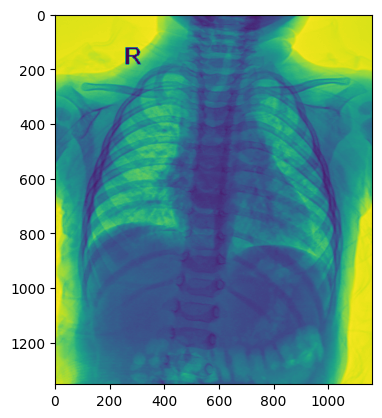

In [ ]:
ds = pydicom.dcmread("test/00c3b26e8581f817b11313e81283a832.dicom")
print(ds)

# Check the TransferSyntaxUID to see if the image is compressed
if ds.file_meta.TransferSyntaxUID.is_compressed:
    # Decompress the pixel data using the appropriate algorithm
    print("Image was compressed.")
    print("Decompressing the image...")
    ds.decompress()

pixel_array = ds.pixel_array
# pixel_array = np.array(pixel_array,dtype=float)
print('Shape:', pixel_array.shape)
print('Data type:', pixel_array.dtype)
print(pixel_array)
plt.imshow(pixel_array)

In [ ]:
arr = np.array(pixel_array, dtype='float')
arr /= 65535
print(np.min(arr), np.max(arr))

0.0 0.058945601586938276


In [ ]:
test_path = "test"
train_path = "train"

In [ ]:
# Building test-labels(y_test)

y_test_l = list()

for file in os.listdir(test_path):
    img_id = file.split('.')[0]
    
    idx = test_labels.loc[test_labels["image_id"] == img_id].index[0]
    # print(img_id, ":",idx)
    y_test_l.append(y_test[idx])

print(y_test_l[0], len(y_test_l[0]))
y_test_l = [np.argmax(pred) for pred in y_test_l]
y_test_l = np.array(y_test_l)
y_test_l = y_test_l.astype('int32')


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 15


In [ ]:
print(y_test_l[0])

4


In [ ]:
# Building train-labels(y_train)
num_count = 0
y_train_l = list()
count = 0

for file in os.listdir(train_path):
    img_id = file.split('.')[0]
    
    idx = train_labels.loc[train_labels["image_id"] == img_id].index[0]
    # print(img_id, ":",idx)
    y_train_l.append(y_train[idx])
    if diseases[np.argmax(y_train[idx])] in diseases_to_be_considered: 
      num_count += 1

y_train_l = np.array(y_train_l)
y_train_l = y_train_l.astype('int32')
print(num_count)

7707


In [ ]:
# y_train_l # list of one hot vector labels
new_shape = (512,512)

# Define a custom image generator function
def custom_image_generator(image_filenames_lst, one_hot_labels, batch_size,augment_data=False,new_size=(512,512),image_channels=1, inDicomFormat=True):
    num_batches = len(one_hot_labels) // batch_size
    while True:
        for batch_index in range(num_batches):  
          batch_images = []
          batch_labels = []
          image_index = 0
          for image_index in range(batch_size):
              i = batch_index * batch_size + image_index
              label = one_hot_labels[i]
              if inDicomFormat:
                image_pixel_array = display_image_shape(image_filenames_lst[i],new_size=new_size,image_channels=image_channels)
                #print(image_pixel_array.shape)
              else:
                image_pixel_array = np.load(image_filenames_lst[i])
              if augment_data:
                  # apply data augmentation techniques like rotation, scaling, flipping, etc.
                  pass
              batch_images.append(image_pixel_array)
              batch_labels.append(label)
          batch_images = np.array(batch_images)
          batch_labels = np.array(batch_labels)
          yield batch_images, batch_labels


####Preprocessing images

In [ ]:
import os
import pydicom
import numpy as np

# def dicom_to_pixel_array(dicom_file):
#     """
#     Converts a DICOM file to a pixel array.
#     """
#     dicom = pydicom.dcmread(dicom_file)
#     return dicom.pixel_array

# display_image_shape(filename,new_size=(512,512),image_channels=1)
# function signature 

def batch_generator(dicom_files, batch_size, image_channels=1):
    """
    Generator function that loads DICOM files in batches and converts them to pixel arrays.
    """
    num_samples = len(dicom_files)
    num_batches = int(np.ceil(num_samples / batch_size))
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch_files = dicom_files[batch_start:batch_end]# Getting the filenames for the respective batch
        batch_images = [display_image_shape(file,new_size=(512,512),image_channels=image_channels) for file in batch_files]
        # batch_images = np.array(batch_images)
        yield batch_images

def save_pixel_arrays(dicom_dir, pixel_array_dir, batch_size=32, image_channels=1):
    """
    Loads DICOM files from the given directory in batches, converts them to pixel arrays, and saves them in the given directory.
    """
    if not os.path.exists(pixel_array_dir):
        os.makedirs(pixel_array_dir)
    dicom_files = [os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dicom')]
    
    num_samples = len(dicom_files)
    batch_gen = batch_generator(dicom_files, batch_size, image_channels) # creating an object of the generator function 
    for i, batch in enumerate(batch_gen):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, num_samples)
        for j in range(start_idx, end_idx):
            pixel_array_file = os.path.join(pixel_array_dir, f'{j}.npy')
            np.save(pixel_array_file, batch[j-start_idx])


In [ ]:
# don't uncomment this, it took 4 minutes
 
# save_pixel_arrays("test", "decompressed_test_3channels", image_channels=3)

In [ ]:
# don't uncomment this, it took 1 hour 27 minutes

# save_pixel_arrays("train", "decompressed_train_3channels", image_channels=3)

####Global functions for all the tests

In [ ]:
def myComparator(e):
  x = e.split(".")[0]
  x = x.split("/")[-1]
  return int(x)


# Load the DICOM images and their corresponding labels
train_path = "decompressed_train_3channels"
image_filenames_lst = os.listdir(train_path)
image_filenames_lst = [os.path.join(train_path,file) for file in image_filenames_lst]
print(len(image_filenames_lst))
print(type(image_filenames_lst))
print(image_filenames_lst)
print("num_count:",num_count)
print(len(y_train_l))
print() 

y_train_l_updated = list()
image_filenames_lst_updated = list()

for i in range(len(y_train_l)):
  if diseases[np.argmax(y_train_l[i])] not in diseases_to_be_considered:
    continue
  y_train_l_updated.append(y_train_l[i][:len(diseases_to_be_considered)])
  image_filenames_lst_updated.append(image_filenames_lst[i])

image_filenames_lst_updated.sort(key=myComparator)
print(image_filenames_lst_updated)

y_train_l_updated = np.array(y_train_l_updated)
# image_filenames_lst_updated = np.array(image_filenames_lst_updated)
print(len(y_train_l_updated), len(image_filenames_lst_updated))
# del y_train_l
# del image_filenames_lst

#### VGG-19 

In [ ]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical

# Load the pre-trained VGG-19 model
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

# Add new fully connected layers
flatten = Flatten()(vgg.output)
fc1 = Dense(1024, activation='relu')(flatten)
fc2 = Dense(512, activation='relu')(fc1)
output = Dense(7, activation='softmax')(fc2)

# Create the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
# Instantiate the custom image generator
batch_size = 20

train_generator = custom_image_generator(image_filenames_lst_updated, y_train_l_updated, batch_size, augment_data=True,image_channels=3,inDicomFormat=False)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

ckpt_mgr = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/vgg-19.h5', monitor='loss', save_best_only=True, save_weights_only=False)

steps_per_epoch = len(y_train_l_updated) // batch_size
print(steps_per_epoch)

385


In [ ]:
# train the model for a few epochs and save the model
# model.fit(train_generator, callbacks=[es, ckpt_mgr], epochs=1,steps_per_epoch=steps_per_epoch)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


385/385 [==============================] - 1854s 5s/step - loss: 329.4857 - accuracy: 0.4769


In [ ]:
# model = load_model('saved_models/vgg-19.h5')
# model.fit(train_generator, callbacks=[es, ckpt_mgr], epochs=10,steps_per_epoch=steps_per_epoch, initial_epoch=1)

Epoch 2/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


385/385 [==============================] - 1703s 4s/step - loss: 245.8601 - accuracy: 0.5184
Epoch 3/10
385/385 [==============================] - 3993s 10s/step - loss: 1389.2992 - accuracy: 0.4983
Epoch 4/10
385/385 [==============================] - 3617s 9s/step - loss: 8382.7119 - accuracy: 0.4761
Epoch 5/10
 67/385 [====>.........................] - ETA: 50:07 - loss: 14383.5254 - accuracy: 0.4507

In [ ]:
# model = load_model('saved_models/vgg-19.h5')
# model.fit(train_generator, callbacks=[es, ckpt_mgr], epochs=10,steps_per_epoch=steps_per_epoch, initial_epoch=4)

Epoch 5/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


385/385 [==============================] - 1436s 4s/step - loss: 1325.4043 - accuracy: 0.5084
Epoch 6/10
385/385 [==============================] - 1582s 4s/step - loss: 8623.8379 - accuracy: 0.4842
Epoch 7/10
385/385 [==============================] - 1356s 4s/step - loss: 37628.2188 - accuracy: 0.4716
Epoch 8/10
385/385 [==============================] - 1312s 3s/step - loss: 107217.1172 - accuracy: 0.4721
Epoch 9/10
385/385 [==============================] - 1351s 4s/step - loss: 300636.9375 - accuracy: 0.4701
Epoch 10/10
385/385 [==============================] - 1320s 3s/step - loss: 697990.5000 - accuracy: 0.4704
Epoch 10: early stopping


In [ ]:
# model = load_model('saved_models/vgg-19.h5')
# model.fit(train_generator, callbacks=[es, ckpt_mgr], epochs=30,steps_per_epoch=steps_per_epoch, initial_epoch=10)

Epoch 11/30
385/385 [==============================] - 1444s 4s/step - loss: 8808.4287 - accuracy: 0.4852
Epoch 12/30
385/385 [==============================] - 1320s 3s/step - loss: 34269.5547 - accuracy: 0.4732
Epoch 13/30
385/385 [==============================] - 1307s 3s/step - loss: 97075.2031 - accuracy: 0.4700
Epoch 14/30
207/385 [===============>..............] - ETA: 10:08 - loss: 188946.8750 - accuracy: 0.4611

####Performance


In [ ]:
def print_model_metrics(y_pred,y_test_l=y_test_l):
    

    # Calculate the f1 score
    f1_s = classification_report(y_test_l[:len(y_pred)], y_pred)
    print("F1-score:-\n",f1_s)

    # Calculate the accuracy
    accuracy = np.mean(y_test_l[:len(y_pred)] == y_pred)
    precision = precision_score(y_test_l[:len(y_pred)], y_pred, average='macro')
    recall = recall_score(y_test_l[:len(y_pred)], y_pred, average='macro')
    print("Accuracy:",accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_l[:len(y_pred)], y_pred)
    print(cm)

    f1 = f1_score(y_test_l[:len(y_pred)], y_pred, average='weighted')
    print('Weighted F1 score:', f1)



    #ROC
    fpr, tpr, thresholds = roc_curve(y_test_l[:len(y_pred)], y_pred, pos_label=2)
    roc_auc = auc(fpr, tpr)


    # plot the ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
##  PERFORMANCE METRICS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

# collecting the test_ as appropriate for the given model
test_path = "decompressed_test_3channels"
x_test = list()
for file in os.listdir(test_path):
    file_path = os.path.join(test_path,file)
    # pixel_array = display_image_shape(file_path,image_channels=1)
    pixel_array = np.load(file_path)
    x_test.append(pixel_array)

x_test = np.array(x_test)

In [ ]:
print(type(x_test))
print(x_test.shape)
print(x_test[0].shape)

<class 'numpy.ndarray'>
(1397, 512, 512, 3)
(512, 512, 3)


####vgg-19

In [ ]:
model = load_model("saved_models/vgg-19.h5")


KeyboardInterrupt: ignored

In [ ]:
model.predict(x_test[0:2])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 10s 10s/step


array([[9.9852210e-01, 1.4779429e-03, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 8.6935570e-23, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
# load the saved model
# model = load_model("saved_models/vgg-19.h5")
batch_size = 100
num_predict = len(x_test) // batch_size
predictions = model.predict(np.array(x_test[:num_predict*batch_size]))
# predictions = model.predict(np.array(x_test))
print(predictions)
print(len(predictions))

# converting the predictions into simple labels
y_pred = list()
for lst in predictions:
    pos = np.argmax(lst)
    ans_lst = [0 for i in range(len(lst))]
    ans_lst[pos] = 1
    y_pred.append(ans_lst)

y_pred = np.array([np.argmax(pred) for pred in predictions])
del predictions


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


41/41 [==============================] - 42s 1s/step
[[9.9852210e-01 1.4779429e-03 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 8.2954499e-23 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [5.6586241e-08 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.6252265e-24 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
1300


In [ ]:
print(len(y_pred))
print(y_pred[0])

1300
0


In [ ]:
print(len(y_test_l))
print(y_test_l[0])

1397
4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

F1-score:-
               precision    recall  f1-score   support

           0       0.67      0.94      0.78       861
           1       0.21      0.12      0.16       163
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        67

    accuracy                           0.64      1300
   macro avg       0.13      0.15      0.13      1300
weighted avg       0.47      0.64      0.54      1300

Accuracy: 0.6369230769230769
Precision: 0.1258665335538015
Recall: 0.15159186523629353
[[808  53   0   0   0   0   0]
 [143  20   0   0   0   0   0]
 [ 57   7   0   0   0   0   0]
 [ 68   3   0   0   0   0   0]
 [ 66   7   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [ 62   5   0   0   0   0   0]]
Weighted F1 score: 0.5374884736896488


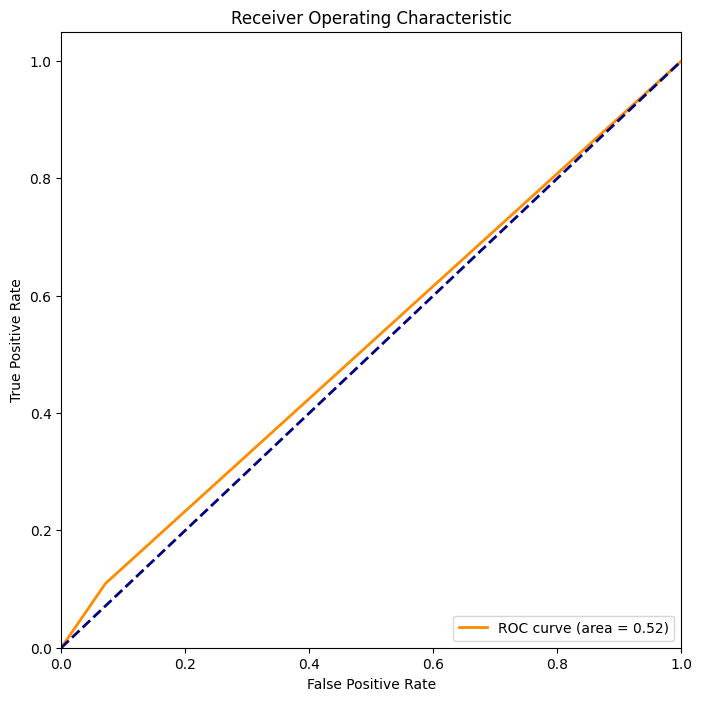

In [ ]:
print_model_metrics(y_pred,y_test_l=y_test_l)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-score:-
               precision    recall  f1-score   support

           0       0.67      0.94      0.78       861
           1       0.21      0.12      0.16       163
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        67

    accuracy                           0.64      1300
   macro avg       0.13      0.15      0.13      1300
weighted avg       0.47      0.64      0.54      1300

Accuracy: 0.6369230769230769
[[808  53   0   0   0   0   0]
 [143  20   0   0   0   0   0]
 [ 57   7   0   0   0   0   0]
 [ 68   3   0   0   0   0   0]
 [ 66   7   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [ 62   5   0   0   0   0   0]]
Weighted F1 score: 0.5374884736896488


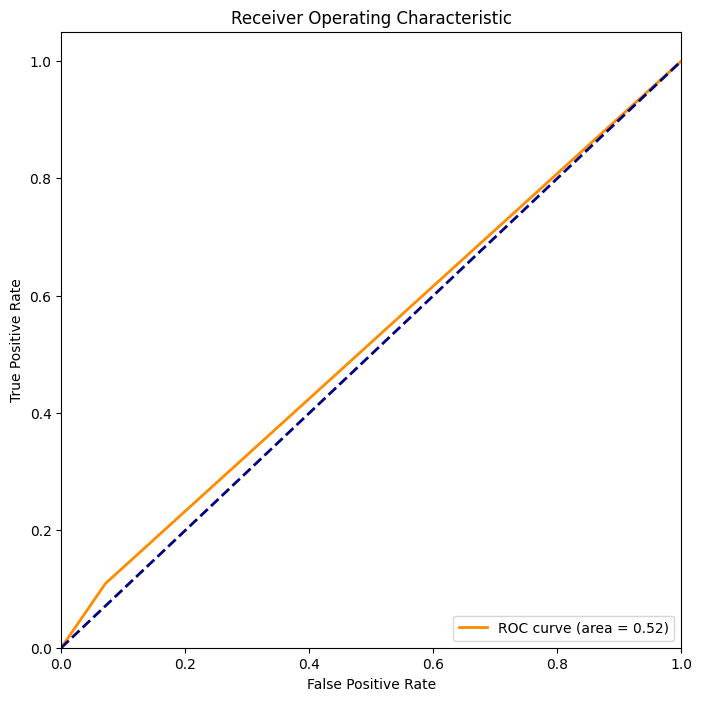

In [ ]:
print_model_metrics(y_pred,y_test_l=y_test_l)

####vgg-16

In [ ]:
model = load_model("saved_models/model2_1.h5")   ##VGG-16
# This was already created in the other code file (CNN & GAN.ipynb) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                3

In [ ]:
print(x_test.shape)
print(x_test[0].shape)


(1397, 512, 512, 3)
(512, 512, 3)


In [ ]:
model.predict(np.array(x_test[0:2]))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 9s 9s/step


array([[0.5476237 , 0.09980851, 0.0658536 , 0.04881939, 0.06360528,
        0.01476846, 0.04541432, 0.01342531, 0.01294914, 0.01467508,
        0.01475983, 0.01616034, 0.01519418, 0.01380222, 0.01314059],
       [0.5476237 , 0.09980851, 0.0658536 , 0.04881939, 0.06360528,
        0.01476846, 0.04541432, 0.01342531, 0.01294914, 0.01467508,
        0.01475983, 0.01616034, 0.01519418, 0.01380222, 0.01314059]],
      dtype=float32)

In [ ]:

batch_size = 100
num_predict = len(x_test) // batch_size
predictions = model.predict(np.array(x_test[:num_predict*batch_size]))
# predictions = model.predict(np.array(x_test))
print(predictions)
print(len(predictions))

# converting the predictions into simple labels
y_pred = list()
for lst in predictions:
    pos = np.argmax(lst)
    ans_lst = [0 for i in range(len(lst))]
    ans_lst[pos] = 1
    y_pred.append(ans_lst)

y_pred = np.array([np.argmax(pred) for pred in predictions])
del predictions


41/41 [==============================] - 69s 1s/step
[[0.5476237  0.09980851 0.0658536  ... 0.01519418 0.01380222 0.01314059]
 [0.5476237  0.09980851 0.0658536  ... 0.01519418 0.01380222 0.01314059]
 [0.5476237  0.09980851 0.0658536  ... 0.01519418 0.01380222 0.01314059]
 ...
 [0.5476237  0.09980851 0.0658536  ... 0.01519418 0.01380222 0.01314059]
 [0.5476237  0.09980851 0.0658536  ... 0.01519418 0.01380222 0.01314059]
 [0.5476237  0.09980851 0.0658536  ... 0.01519418 0.01380222 0.01314059]]
1300


In [ ]:
print(y_pred)
print(y_test_l)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

F1-score:-
               precision    recall  f1-score   support

           0       0.66      1.00      0.80       861
           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        67

    accuracy                           0.66      1300
   macro avg       0.09      0.14      0.11      1300
weighted avg       0.44      0.66      0.53      1300

Accuracy: 0.6623076923076923
Precision: 0.09461538461538462
Recall: 0.14285714285714285
[[861   0   0   0   0   0   0]
 [163   0   0   0   0   0   0]
 [ 64   0   0   0   0   0   0]
 [ 71   0   0   0   0   0   0]
 [ 73   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [ 67   0   0   0   0   0   0]]
Weighted F1 score: 0.5277620759619834


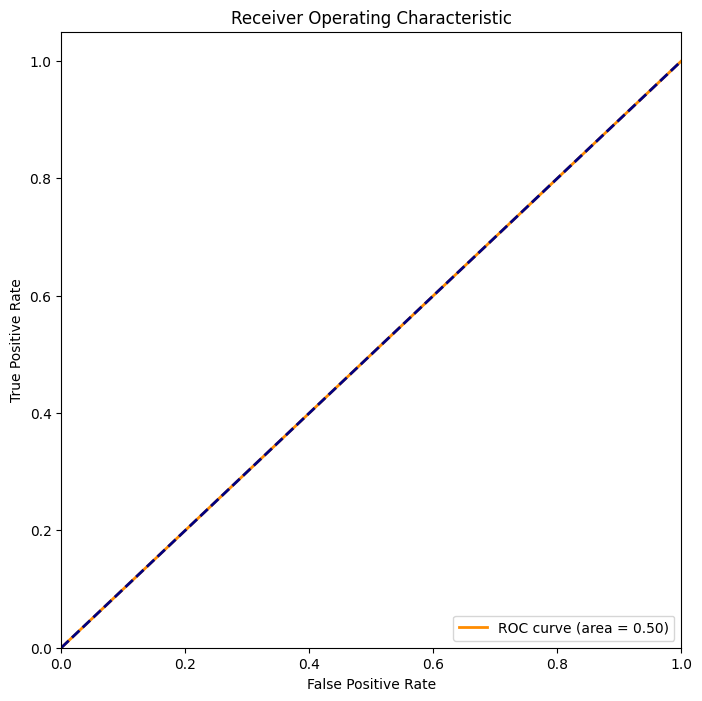

In [ ]:
print_model_metrics(y_pred,y_test_l=y_test_l)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-score:-
               precision    recall  f1-score   support

           0       0.66      1.00      0.80       861
           1       0.00      0.00      0.00       163
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        67

    accuracy                           0.66      1300
   macro avg       0.09      0.14      0.11      1300
weighted avg       0.44      0.66      0.53      1300

Accuracy: 0.6623076923076923
[[861   0   0   0   0   0   0]
 [163   0   0   0   0   0   0]
 [ 64   0   0   0   0   0   0]
 [ 71   0   0   0   0   0   0]
 [ 73   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [ 67   0   0   0   0   0   0]]
Weighted F1 score: 0.5277620759619834


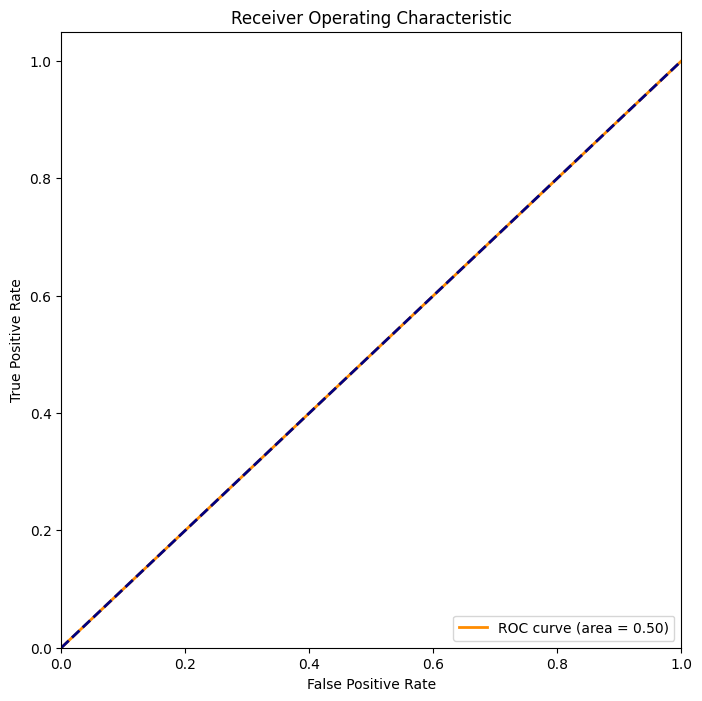

In [ ]:
print_model_metrics(y_pred,y_test_l=y_test_l)